Thư viện


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


In [ ]:


from nltk.tokenize import word_tokenize


Đọc dữ liệu

In [ ]:
import os
documents = []
from google.colab import drive
drive.mount('/content/drive')

for doc in os.listdir('/content/drive/MyDrive/NLP/documents/'):
    with open('/content/drive/MyDrive/NLP/documents/' + doc, encoding='utf-8') as f:
        documents.append(f.read())

print("Number of documents: ", len(documents))
for i in range(0,2):
    print(documents[i] + '\n')


Mounted at /content/drive
Number of documents:  300
Tôi thích đọc sách mỗi tối.
Những trang sách giúp tôi thư giãn sau một ngày dài.


Con mèo của tôi rất nghịch ngợm.
Nó thường leo lên tủ và làm đổ đồ.



Tạo danh sách lưu từng mẫu dữ liệu


In [ ]:
class Loader:
    def __init__(self, _data) -> None:
        self.data = _data

    def load_data(self):
        data_str = []  # Chuỗi để lưu trữ nội dung các tệp tin
        for doc in os.listdir(self.data):
            with open(f"{self.data}/{doc}", 'r', encoding='utf-8') as f:
                data_str.append(f.read().splitlines())  # Thêm nội dung của từng tệp tin vào chuỗi
        return data_str  # Trả về chuỗi đã ghép nối


Tiền xử lí dữ liệu

In [ ]:
stop_words = set(open('/content/drive/MyDrive/NLP/STW/stopwords.txt', encoding='utf-8').read().split('\n')[:-1])
puct_set = set([c for c in "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"])

# data = '/content/drive/MyDrive/NLP/documents'
data = '/content/drive/MyDrive/NLP/documents'

class Preprocessing(Loader):
    def __init__(self, _data, stop_words, puct_set) -> None:
        super().__init__(_data)
        self.data_list = self.load_data()
        self.stop_words = stop_words
        self.puct_set = puct_set

    def tokenizer(self, text):
        return word_tokenize(text)

    def generateBigram(self, text):
        words = text.split()
        if len(words) == 1:
            return ''
        bigrams = [words[i] + '_' + words[i+1] for i in range(0, len(words) - 1)]
        return ' '.join(bigrams)

    def removeRedundant(self, text):
        stop_words_set = self.stop_words
        puct_set = self.puct_set
        words = text.split()
        for i in range(0, len(words)):
            if words[i].count('_') == 0 and (words[i] in stop_words_set | puct_set or words[i].isdigit()):
                words[i] = ''
            else:
                sub_words = words[i].split('_')
                if any(w in stop_words_set | puct_set or w.isdigit() for w in sub_words):
                    words[i] = ''
        words = [w for w in words if w != '']
        return ' '.join(words)

    # Đưa method pre vào đây
    def pre(self):
        prep_data = []
        text = self.data_list
        for i in range(len(text)):
            prep_text = ' '.join(text[i])
            prep_text = ' '.join(self.tokenizer(prep_text))
            prep_text = prep_text.lower()
            prep_text = ' '.join(prep_text.split())
            prep_text = self.generateBigram(prep_text)
            prep_text = self.removeRedundant(prep_text)
            prep_data.append(prep_text)
        return prep_data


Gọi hàm tiền xử lí và in ra 5 mẫu đầu tiên sau tiền xử lí

In [ ]:
prep = Preprocessing(data, stop_words, puct_set)
text = prep.pre()

for i in range(0, 5):
    print(text[i] + '\n')


đọc_sách trang_sách sách_giúp thư_giãn giãn_sau

nghịch_ngợm đổ_đồ

dậy_muộn vội_vàng

cà_phê thức_uống uống_yêu

trời_mưa đường_phố phố_ngập giao_thông thông_ùn ùn_tắc



Biến dữ liệu thành dạng số và giảm chiều dữ liệu

In [ ]:
vectorizer = TfidfVectorizer(token_pattern = "\S+", min_df = 2)
vectors = vectorizer.fit_transform(text)

print("Tf-idf shape: ZAA" + str(vectors.shape))

svd = TruncatedSVD(n_components=15, n_iter=20, random_state=42)
svd_vectors = svd.fit_transform(vectors)
print(svd_vectors.shape)
print("Document 1's Vector : ")
print(svd_vectors[0])


Tf-idf shape: ZAA(300, 412)
(300, 15)
Document 1's Vector : 
[ 0.00744227  0.22076956  0.08781534  0.16996813  0.13360302 -0.10076751
 -0.02588596 -0.10326297 -0.12303448 -0.02012183  0.15218247 -0.06608392
 -0.0088351  -0.25591201  0.03255226]


Phân cụm dữ liệu với K-Means

In [ ]:

from sklearn.cluster import KMeans


n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=400)
kmeans.fit(svd_vectors)


KMeans(max_iter=400, n_clusters=7, random_state=42)

Kết quả phân cụm

In [ ]:
# Gán nhãn cụm cho mỗi văn bản
labels = kmeans.labels_

# Tạo một từ điển để nhóm các văn bản vào từng cụm
clusters = {}
for idx, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(idx)

# In ra các văn bản thuộc mỗi cụm
for cluster_id, doc_indices in clusters.items():
    print(f"Cụm {cluster_id}: {len(doc_indices)} văn bản")
    print("Danh sách văn bản:")
    for doc_idx in doc_indices:
        print(f"Văn bản \n --{text[doc_idx]}")  # dùng biến `text` đã qua tiền xử lý
    print("\n")



Cụm 4: 14 văn bản
Danh sách văn bản:
Văn bản 
 --đọc_sách trang_sách sách_giúp thư_giãn giãn_sau
Văn bản 
 --nhẹ_nhàng nhàng_giúp thư_giãn
Văn bản 
 --thức_dậy ngắm_bình bình_minh ban_công công_tầng tầng_thượng bầu_trời trời_nhuộm nhuộm_sắc sắc_hồng hồng_cam cam_nhẹ nhẹ_nhàng đám_mây mây_trôi trôi_lững lững_lờ thư_thái thái_lạ
Văn bản 
 --ghé_quán quán_cơm cơm_chay chay_quen thưởng_thức thức_bữa nhẹ_nhàng món_đậu đậu_hũ hũ_kho kho_tiêu canh_rong rong_biển
Văn bản 
 --thời_gian kỹ_thuật thuật_thở thở_giúp căng_thẳng cải_thiện thiện_giấc giấc_ngủ phút_tập tập_trung trung_hít hít_thở thở_sâu nhẹ_nhàng giấc_ngủ
Văn bản 
 --căng_thẳng thư_giãn ngâm_chân muối_thảo thảo_dược liệu_pháp ngủ_ngon nhẹ_nhàng hôm_sau
Văn bản 
 --quán_cà cà_phê phê_yên yên_tĩnh đọc_sách không_gian gian_nhẹ nhẹ_nhàng mùi_thơm cà_phê phê_giúp tập_trung
Văn bản 
 --thói_quen nhạc_cổ cổ_điển âm_nhạc nhạc_nhẹ nhẹ_nhàng nhàng_giúp giúp_tâm tâm_trí thư_giãn
Văn bản 
 --thử_thiền tâm_trí trí_nhẹ nhẹ_nhàng giấc_ngủ ngủ_sâu
V

Đánh giá mô hình bằng các độ đo Silhouette Score, Davies-Bouldin Index và Calinski-Harabasz Index

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.datasets import make_blobs

# Silhouette Score
silhouette_avg = silhouette_score(svd_vectors, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index
db_index = davies_bouldin_score(svd_vectors, labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(svd_vectors, labels)
print(f"Calinski-Harabasz Index: {ch_index}")


Silhouette Score: 0.25821018340920737
Davies-Bouldin Index: 1.2627427634085744
Calinski-Harabasz Index: 44.60445679741981


Trực Quan Hóa Phân cụm

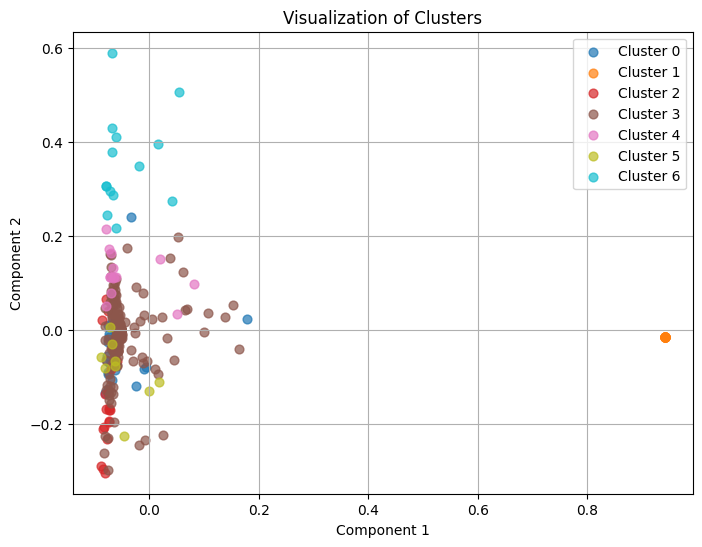

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Giảm chiều từ 15 (svd_vectors) xuống 2D để trực quan hóa
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(svd_vectors)

# Vẽ biểu đồ scatter các cụm
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    plt.scatter(
        reduced_vectors[labels == i, 0],
        reduced_vectors[labels == i, 1],
        label=f"Cluster {i}",
        alpha=0.7,
        s=40,
        color=colors[i]
    )

plt.title("Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()
